In [1]:
import os
import sys

import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import plot


In [2]:
import django
# for django async setting
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ['DJANGO_ALLOW_ASYNC_UNSAFE'] = 'true'
django.setup()

In [3]:
# my util functions
from ra_exploer.views import filterQuery
from utils.TR2_tools import tr2_score

In [9]:
query = {
    'LC': ['LCT-15-1098', 'SLC19V33'],
    'PI': ['ALL'],
    'Seal': ['ALL'],
}

result, result_mean = filterQuery(query, VHR)

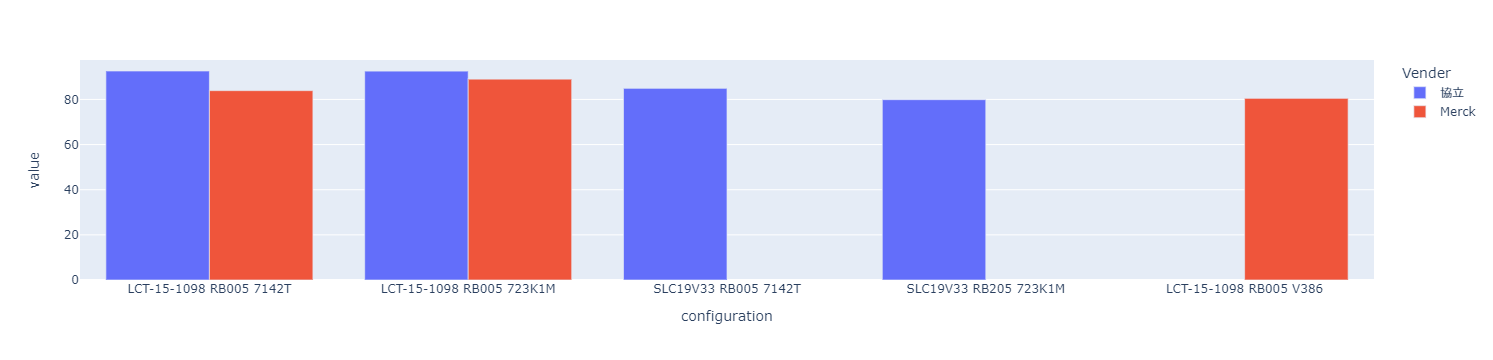

In [14]:
fig = px.bar(result_mean, x='configuration', y='value', 
       color='Vender', barmode='group')
fig.show()

In [21]:
# transfer to html
result_mean.to_html(float_format=lambda x: f'{x:.2f}', index=False)

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>item</th>\n      <th>LC</th>\n      <th>PI</th>\n      <th>Seal</th>\n      <th>Vender</th>\n      <th>value</th>\n      <th>configuration</th>\n      <th>score</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>VHR(heat)</td>\n      <td>LCT-15-1098</td>\n      <td>RB005</td>\n      <td>7142T</td>\n      <td>協立</td>\n      <td>92.60</td>\n      <td>LCT-15-1098 RB005 7142T</td>\n      <td>1.21</td>\n    </tr>\n    <tr>\n      <td>VHR(heat)</td>\n      <td>LCT-15-1098</td>\n      <td>RB005</td>\n      <td>723K1M</td>\n      <td>協立</td>\n      <td>92.56</td>\n      <td>LCT-15-1098 RB005 723K1M</td>\n      <td>1.20</td>\n    </tr>\n    <tr>\n      <td>VHR(heat)</td>\n      <td>LCT-15-1098</td>\n      <td>RB005</td>\n      <td>723K1M</td>\n      <td>Merck</td>\n      <td>89.00</td>\n      <td>LCT-15-1098 RB005 723K1M</td>\n      <td>0.53</td>\n    </tr>\n    <tr>\n      <td>VHR(heat)</t

In [103]:
import sys
import importlib



In [104]:
importlib.reload(sys.modules[tr2_score.__module__])

<module 'utils.TR2_tools' from 'F:\\dimsp\\Documents\\Projects\\td_toolkits_reconstruc\\utils\\TR2_tools.py'>

In [107]:
a = tr2_score(result_mean['value'],method='min-max', formatter=lambda x: np.round(x*10))

In [108]:
a

1    10.0
3    10.0
2     7.0
5     4.0
0     3.0
4     0.0
6     0.0
Name: value, dtype: float64

In [121]:
x = 
for i in x:
    print (x.name)

AttributeError: 'QuerySet' object has no attribute 'name'

In [123]:
type(OpticsLogTest.objects.all())

django.db.models.query.QuerySet

In [138]:
pd.DataFrame.from_records(OpticsLogTest.objects.all().values("iquidCrystal__name").distinct())

,liquidCrystal__name
0,843001
1,LCT-15-1098
2,LCT-19-580
3,MOX-1
4,SLC19V33
5,SLC20V87
6,ZIX-7054XX


In [68]:
q = {
    'LC': ['LCT-15-1098', 'SLC19V33'],
    'PI': 'ALL',
    'Seal': 'ALL'
}

_, vhr_df = filterQuery(q, VHR)
_, lts_df = filterQuery(q, LowTemperatureStorage)
mean_df = pd.concat([vhr_df, lts_df], ignore_index=True)

In [72]:
tmp_df = mean_df[['item', 'configuration', 'score']].groupby(by=['item', 'configuration']).mean()
tmp_df = tmp_df.unstack(level=0)
tmp_df = tmp_df.fillna(0)

In [73]:
tmp_df[('score', 'Sum')] = tmp_df.sum(axis=1)

In [74]:
tmp_df = tmp_df.sort_values(by=('score', 'Sum'), ascending=False)

In [75]:
tmp_df

score               
item                           LTS VHR(heat)  Sum
configuration                                    
LCT-15-1098 RB005 723K1M       0.0       8.5  8.5
LCT-15-1098 RB005 7142T        0.0       7.0  7.0
SLC19V33 N.A. N.A.             7.0       0.0  7.0
SLC19V33 RB005 7142T           0.0       5.0  5.0
SLC19V33 SE-7492 XN-5490H      5.0       0.0  5.0
LCT-15-1098 N.A. N.A.          1.0       0.0  1.0
LCT-15-1098 RB005 V386         0.0       1.0  1.0
LCT-15-1098 SE-7492 XN-5490H   1.0       0.0  1.0
SLC19V33 RB205 723K1M          0.0       1.0  1.0

In [76]:
tmp_df = tmp_df.droplevel(0, axis=1).reset_index()

In [77]:
plot_df = tmp_df.set_index('configuration').stack().reset_index()
plot_df.columns = ['Configuration', 'Item', 'Score']

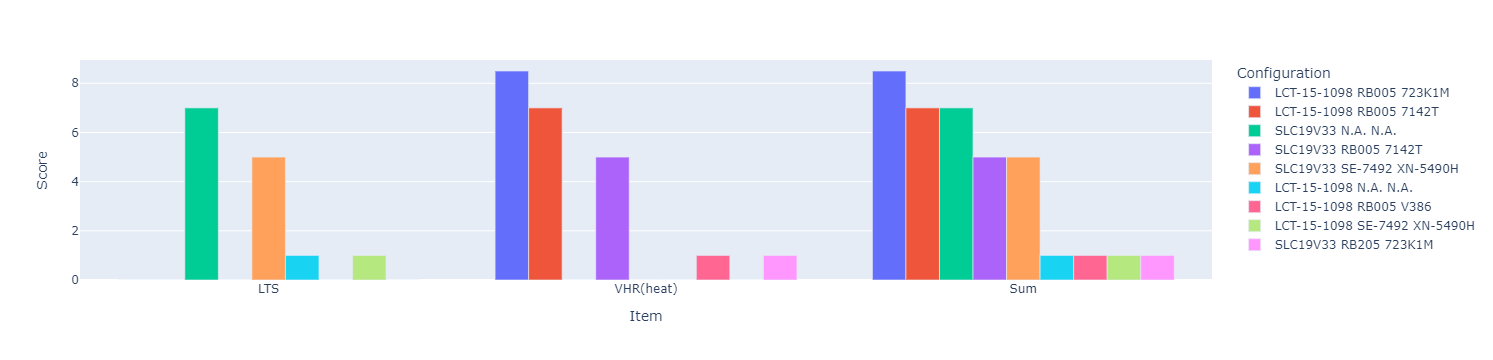

In [78]:
fig = px.bar(
    plot_df,
    x='Item',
    y='Score',
    color='Configuration',
    barmode='group'
)
fig.show()

In [81]:

tmp_df[list(tmp_df.columns).pop()]

0    8.5
1    7.0
2    7.0
3    5.0
4    5.0
5    1.0
6    1.0
7    1.0
8    1.0
Name: Sum, dtype: float64

In [88]:
tmp_df.columns.name = None
tmp_df

,configuration,LTS,VHR(heat),Sum
0,LCT-15-1098 RB005 723K1M,0.0,8.5,8.5
1,LCT-15-1098 RB005 7142T,0.0,7.0,7.0
2,SLC19V33 N.A. N.A.,7.0,0.0,7.0
3,SLC19V33 RB005 7142T,0.0,5.0,5.0
4,SLC19V33 SE-7492 XN-5490H,5.0,0.0,5.0
5,LCT-15-1098 N.A. N.A.,1.0,0.0,1.0
6,LCT-15-1098 RB005 V386,0.0,1.0,1.0
7,LCT-15-1098 SE-7492 XN-5490H,1.0,0.0,1.0
8,SLC19V33 RB205 723K1M,0.0,1.0,1.0


In [3]:
q_lc_list = LiquidCrystal.objects.filter(name__in=['LCT-15-1098', 'SLC19V33'])

In [6]:
OpticsLogTest.objects.filter(liquidCrystal__in=q_lc_list).count()

110

In [29]:
from django.db.models import F
q = OpticsLogTest.objects \
    .filter(liquidCrystal__in=q_lc_list, v_percent='V99') \
    .annotate(designed_cell_gap=F('liquidCrystal__designed_cell_gap')) \
    .filter(cell_gap=F('designed_cell_gap'))

In [30]:
import pandas as pd
df = pd.DataFrame.from_records(q.values())
df.head()

,id,batch_id,liquidCrystal_id,v90,v95,v99,v100,vop,v_percent,platform_id,...,delta_contrast_ratio,transmittance,dark_index,white_index,time_rise,time_fall,response_time,g2g,remark,designed_cell_gap
0,552,2,3,4.6410,5.1790,6.4221,6.9691,6.4221,V99,1,...,32.39,99.300,0.021301885,99.300480799,7.577488764,10.193125627,17.791768047,21.764442842,Interpolation,3.0
1,602,2,4,4.3624,4.8296,5.9149,6.3936,5.9149,V99,1,...,3.95,99.344,0.027143005,99.344363226,8.158473158,10.734692507,18.913386317,23.136504161,Interpolation,2.9


In [28]:
df[['liquidCrystal_id','v_percent', 'cell_gap', 'designed_cell_gap']]

,liquidCrystal_id,v_percent,cell_gap,designed_cell_gap
0,3,V90,3.00,3.0
1,3,V95,3.00,3.0
2,3,V99,3.00,3.0
3,3,V100,3.00,3.0
4,3,Vref,3.00,3.0
5,4,V90,2.90,2.9
6,4,V95,2.90,2.9
7,4,V99,2.90,2.9
8,4,V100,2.90,2.9
9,4,Vref,2.90,2.9


In [33]:
q2 = OpticsLogTest.objects.filter(
    liquidCrystal__in=q_lc_list, 
    v_percent='V99', 
    cell_gap=F('liquidCrystal__designed_cell_gap')
)

In [34]:
import pandas as pd
df = pd.DataFrame.from_records(q2.values())
df.head()

,id,batch_id,liquidCrystal_id,v90,v95,v99,v100,vop,v_percent,platform_id,...,contrast_ratio,delta_contrast_ratio,transmittance,dark_index,white_index,time_rise,time_fall,response_time,g2g,remark
0,552,2,3,4.6410,5.1790,6.4221,6.9691,6.4221,V99,1,...,1867.8,32.39,99.300,0.021301885,99.300480799,7.577488764,10.193125627,17.791768047,21.764442842,Interpolation
1,602,2,4,4.3624,4.8296,5.9149,6.3936,5.9149,V99,1,...,1466.5,3.95,99.344,0.027143005,99.344363226,8.158473158,10.734692507,18.913386317,23.136504161,Interpolation


In [35]:
print(q2.query)

SELECT "tr2calculator_opticslogtest"."id", "tr2calculator_opticslogtest"."batch_id", "tr2calculator_opticslogtest"."liquidCrystal_id", "tr2calculator_opticslogtest"."v90", "tr2calculator_opticslogtest"."v95", "tr2calculator_opticslogtest"."v99", "tr2calculator_opticslogtest"."v100", "tr2calculator_opticslogtest"."vop", "tr2calculator_opticslogtest"."v_percent", "tr2calculator_opticslogtest"."platform_id", "tr2calculator_opticslogtest"."cell_gap", "tr2calculator_opticslogtest"."lc_percent", "tr2calculator_opticslogtest"."ref_record_id", "tr2calculator_opticslogtest"."wx", "tr2calculator_opticslogtest"."wy", "tr2calculator_opticslogtest"."u_prime", "tr2calculator_opticslogtest"."v_prime", "tr2calculator_opticslogtest"."delta_uv", "tr2calculator_opticslogtest"."a_star", "tr2calculator_opticslogtest"."b_star", "tr2calculator_opticslogtest"."l_star", "tr2calculator_opticslogtest"."delta_a_star", "tr2calculator_opticslogtest"."delta_b_star", "tr2calculator_opticslogtest"."delta_l_star", "tr2